In [1]:
import torch
from torch import nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, GaussianBlur
import numpy as np
import skimage
import skimage.io
import skimage.data
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import time
import copy
import sys

from torch.utils.tensorboard import SummaryWriter
import torchvision
import tensorflow as tf

In [2]:
downscale_factor = 1/2 # 1/4 of the original size
upscale_factor = 2 # n times bigger than the downscale size

RGB_MODE = False

OPTIM = 'ADAM' # write the optimizer
              # possible choice of the optimizer
              # ['SGD', 'ADAM', 'ADAMAX', 'ASGD', 'ADAGRAD']
              
LR = 1e-4 # default value of lr 1e-4
MOMENTUM = 0 # defaul value for SGD
WEIGHT_DECAY = 0 # default value 0  
DECAY = 0 # default value 0 

OMEGA_0 = 30
FIRST_OMEGA_0 = 30
HIDDEN_OMEGA_0 = 30

IN_FEATURES = 2
if RGB_MODE:
  OUT_FEATURES = 3 # standard 1 for gray scale, 3 for RBG case
                   # 3 experiments to change the parameters of the 3 layers 
                   # and compare with the "base" form of ImageFitting.
else:
  OUT_FEATURES = 1

HIDDEN_FEATURES = 256
HIDDEN_LAYERS = 3
TOTAL_STEPS = 500

In [3]:
def my_get_mgrid(side1, side2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = torch.linspace(-1, 1, steps=side1)
    tensors2 = torch.linspace(-1, 1, steps=side2)
    print(tensors.shape)
    print(tensors2.shape)
    mgrid = torch.stack(torch.meshgrid(tensors, tensors2), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

# SIREN architecture

In [4]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=OMEGA_0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
                
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate      


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=FIRST_OMEGA_0, hidden_omega_0=HIDDEN_OMEGA_0):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [5]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div

def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [6]:
def load_image(scalefactor, activate_blur=False):
  img = skimage.io.imread('./old_car_2.png')
  if RGB_MODE is False:
    img = skimage.color.rgb2gray(img) # comment this for rgb case
  img = Image.fromarray(img)
  if activate_blur:       
    transform = Compose([
          #Resize(sidelength),
          #GaussianBlur(kernel_size=(21, 21), sigma=50),
          ToTensor(),
          Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
  else:
    transform = Compose([
        #Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
  img = transform(img)
  img = nn.functional.interpolate(img.view(1, img.shape[0], img.shape[1], 
                                           img.shape[2]), 
                                  scale_factor=scalefactor, 
                                  mode='bilinear',
                                  align_corners=True
                                  )
  #print(img.shape)
  if RGB_MODE:
    plt.imshow(img.squeeze().permute(1, 2, 0)) # uncomment this if you are in the rgb case
  else:
    plt.imshow(np.squeeze(img.view((img.shape[1], img.shape[2], img.shape[3])))) # comment this if you are in rgb case
  return torch.reshape(img, (img.shape[1], img.shape[2], img.shape[3]))

In [7]:
class MyImageFitting(Dataset):
    def __init__(self, scalefactor, activate_blur=False):
        super().__init__()

        img = load_image(scalefactor, activate_blur=activate_blur)
        self.side_h = img.shape[1]
        self.side_w = img.shape[2]
        if RGB_MODE:
          self.pixels = img.permute(1, 2, 0).view(-1, 3)
        else:
          self.pixels = img.permute(1, 2, 0).view(-1, 1) # in rgb case view function must be .view(-1, 3) otherwise (-1, 1)
        self.coords = my_get_mgrid(self.side_h, self.side_w, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [8]:
import scipy.ndimage
    
class PoissonEqn(Dataset):
    def __init__(self, downscale_factor):
        super().__init__()
        #img = get_cameraman_tensor(sidelength)
        img = load_image(downscale_factor)
        self.side_h = img.shape[1]
        self.side_w = img.shape[2]

        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        #self.coords = get_mgrid(sidelength, 2)
        self.coords = my_get_mgrid(self.side_h, self.side_w, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of 

torch.Size([256])
torch.Size([256])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

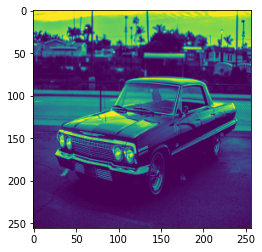

In [9]:
img_poisson = PoissonEqn(downscale_factor)
dataloader = DataLoader(img_poisson, batch_size=1, pin_memory=True, num_workers=0)

poisson_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                      hidden_layers=3, outermost_linear=True)
poisson_siren.cuda()

poisson_siren.train()

In [10]:
def gradients_mse(model_output, coords, gt_gradients):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

def approximate(loss_grad, loss):
  '''
    function to get the magnitude step between the loss of ground truth (gt)
    and the loss of the gradient
  '''
  step = loss_grad
  step_gt = loss
  odg = 0

  while (step * 10) > step_gt:
    
    step = step / 10
    odg += 1

  step = 1 * 10**(-1 * odg)
  return step

# Training the network

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
LOSS 0.405399	 LOSS_GRAD 20.152849	 DIFF 0.001000	 LossDIFF 0.020153	 FINAL_LOSS 0.425552
LOSS 0.098110	 LOSS_GRAD 20.021118	 DIFF 0.000100	 LossDIFF 0.002002	 FINAL_LOSS 0.100112
LOSS 0.051478	 LOSS_GRAD 25.035538	 DIFF 0.000100	 LossDIFF 0.002504	 FINAL_LOSS 0.053982
LOSS 0.038916	 LOSS_GRAD 29.386000	 DIFF 0.000100	 LossDIFF 0.002939	 FINAL_LOSS 0.041855
LOSS 0.032588	 LOSS_GRAD 32.253094	 DIFF 0.000100	 LossDIFF 0.003225	 FINAL_LOSS 0.035813
LOSS 0.028340	 LOSS_GRAD 39.105675	 DIFF 0.000010	 LossDIFF 0.000391	 FINAL_LOSS 0.028731
LOSS 0.025368	 LOSS_GRAD 45.820148	 DIFF 0.000010	 LossDIFF 0.000458	 FINAL_LOSS 0.025826
LOSS 0.023026	 LOSS_GRAD 51.480415	 DIFF 0.000010	 LossDIFF 0.000515	 FINAL_LOSS 0.023541
LOSS 0.021006	 LOSS_GRAD 56.835846	 DIFF 0.000010	 LossDIFF 0.000568	 FINAL_LOSS 0.021575
LOSS 0.019204	 LOSS_GRAD 62.589512	 DIFF 0.000010	 LossDIFF 0.000626	 FINAL_LOSS 0.019830
LOSS 0.017602	 LOSS_GRAD 69.

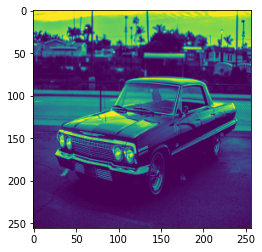

In [11]:
imgFitting = MyImageFitting(scalefactor=downscale_factor)
dataloader = DataLoader(imgFitting, batch_size=1, pin_memory=True, num_workers=0)
img_poisson = PoissonEqn(downscale_factor)

imageSizeH = img_poisson.side_h
imageSizeW = img_poisson.side_w

dataloader_poisson= DataLoader(img_poisson, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=IN_FEATURES, out_features=OUT_FEATURES, hidden_features=HIDDEN_FEATURES, 
                  hidden_layers=HIDDEN_LAYERS, outermost_linear=True)
img_siren.cuda()
img_siren.train()

STEP_SIZE = 280
GAMMA = 0.1

if OPTIM == 'ADAM':
  optim = torch.optim.Adam(lr=LR, weight_decay=WEIGHT_DECAY, params=img_siren.parameters())
elif OPTIM == 'SGD':
  optim = torch.optim.SGD(lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, params=img_siren.parameters())
elif OPTIM == 'ADAMAX':
  optim = torch.optim.Adamax(lr=LR, weight_decay=WEIGHT_DECAY, params=img_siren.parameters())
scheduler = opt.lr_scheduler.StepLR(optim, step_size=STEP_SIZE, gamma=GAMMA)

#total_steps = TOTAL_STEPS # Since the whole image is our dataset, this just means 500 gradient descent steps.
total_steps = 1200
steps_til_summary = 10

# default lr = 1e-4
  
total_loss = 0 
lst_loss = list()
lst_loss_gt = list()
lst_loss_grad = list()
lst_psnr = list()
lst_ssim = list()
best_loss = 99
best_model = -1

# PoissonEqn mode 
model_input, gt = next(iter(dataloader_poisson))
gt = {key: value.cuda() for key, value in gt.items()}

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)

    loss = ((model_output - ground_truth)**2).mean()
    loss_grad = gradients_mse(model_output, coords, gt['grads'])
   
    diff = approximate(loss_grad, loss)
    final_loss = loss + loss_grad  * diff 

    if loss < best_loss:
      best_loss = loss
      best_model = copy.deepcopy(img_siren.state_dict())

    if not step % steps_til_summary:
        #print("Step %d, Total loss %0.6f" % (step, final_loss))
        print("LOSS {:.6f}\t LOSS_GRAD {:.6f}\t DIFF {:.6f}\t LossDIFF {:.6f}\t FINAL_LOSS {:.6f}".format(loss, loss_grad, diff, diff*loss_grad ,final_loss))
        
    # Gray case
    if RGB_MODE:
      psnr = peak_signal_noise_ratio(ground_truth.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy())
      ssim = structural_similarity(ground_truth.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy(), multichannel=True)
    else:
      psnr = peak_signal_noise_ratio(ground_truth.cpu().view(imageSizeH, imageSizeW).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW).detach().numpy())
      ssim = structural_similarity(ground_truth.cpu().view(imageSizeH, imageSizeW).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW).detach().numpy())
    
    lst_psnr.append(psnr)
    lst_ssim.append(ssim)
    lst_loss.append(final_loss)
    lst_loss_gt.append(loss)
    lst_loss_grad.append(loss_grad)

    total_loss = total_loss + loss

    # tb.add_scalar('Loss', loss, step)
    # tb.add_scalar('Total Loss', total_loss, step)
    # tb.add_scalar('PSNR', psnr, step)
    # tb.add_scalar('SSIM', ssim, step)

    optim.zero_grad()
    final_loss.backward()
    optim.step()

    #SCHEDULER STEP 
    scheduler.step()

#ok = model_output.cpu().view(imageSizeH,imageSizeW).detach().numpy()
#tb.add_image('SIREN Training',ok, dataformats='HW')

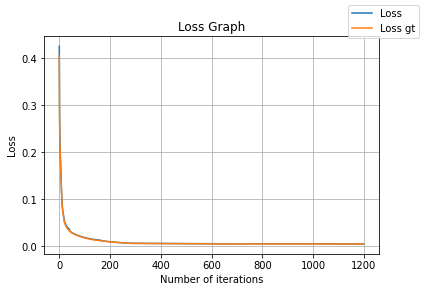

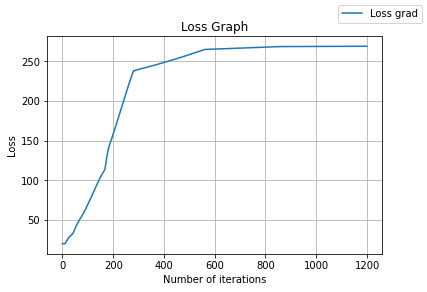

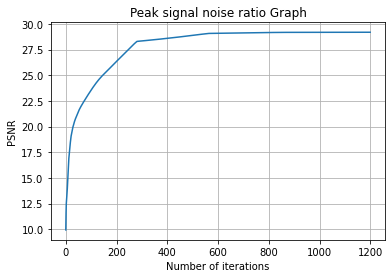

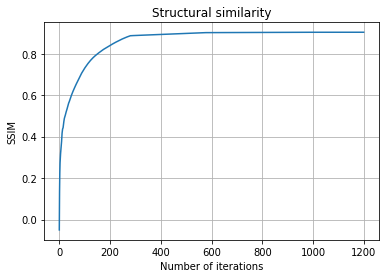

In [12]:
fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_loss, label='Loss')
plt.errorbar(range(0, total_steps), lst_loss_gt, label='Loss gt') # groud truth
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.grid(True)
fig.legend()
plt.show()

fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_loss_grad, label='Loss grad')
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.grid(True)
fig.legend()
plt.show()

fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_psnr, label='PSNR')
plt.title('Peak signal noise ratio Graph')
plt.ylabel('PSNR')
plt.xlabel('Number of iterations')
plt.grid(True)
plt.show()

fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_ssim, label='SSIM')
plt.title('Structural similarity')
plt.ylabel('SSIM')
plt.xlabel('Number of iterations')
plt.grid(True)
plt.show()

# Test phase

In [13]:
bigImageSizeH = imageSizeH * upscale_factor
bigImageSizeW = imageSizeW * upscale_factor

img_siren.load_state_dict(best_model)
print('Load model with best loss {}'.format(best_loss))

img_siren.eval()

Load model with best loss 0.004819734022021294


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([512])
torch.Size([512])
PSNR:  26.849180653288226
SSIM:  0.8152156490761172


Text(0.5, 1.0, 'SIREN')

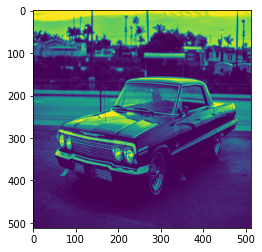

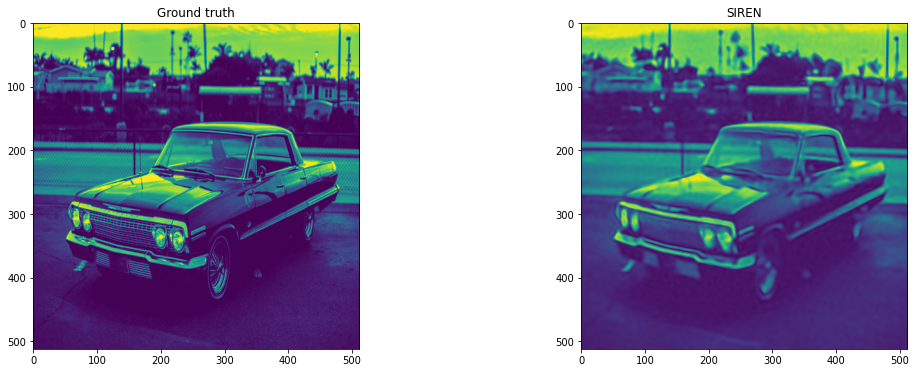

In [14]:
imgFitting = MyImageFitting(scalefactor=upscale_factor*downscale_factor)
dataloader = DataLoader(imgFitting, batch_size=1, pin_memory=True, num_workers=0)
       
img = load_image(downscale_factor * upscale_factor)

model_input, ground_truth = next(iter(dataloader))
model_input = model_input.cuda()
model_output, coords = img_siren(model_input)

if RGB_MODE:
  psnr = peak_signal_noise_ratio(img.squeeze().permute(1, 2, 0).numpy(), model_output.cpu().view(bigImageSizeH, bigImageSizeW, 3).detach().numpy())
  ssim = structural_similarity(img.squeeze().permute(1, 2, 0).numpy(), model_output.cpu().view(bigImageSizeH, bigImageSizeW, 3).detach().numpy(), multichannel=True)
else:
  psnr = peak_signal_noise_ratio(img.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), model_output.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
  ssim = structural_similarity(img.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), model_output.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), multichannel=True)
print('PSNR: ', psnr)
print('SSIM: ', ssim)

fig, axes = plt.subplots(1,2, figsize=(18,6))
if RGB_MODE:
  axes[0].imshow(img.squaeeze().permute(1, 2, 0))
else:
  axes[0].imshow(img.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
axes[0].set_title('Ground truth')
if RGB_MODE:
  axes[1].imshow(model_output.cpu().view(bigImageSizeH, bigImageSizeW, 3).detach().numpy())
else:     
  axes[1].imshow(model_output.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
axes[1].set_title('SIREN')

#string = 'PSRN=' + str(psnr) + '  SSIM=' + str(ssim)
#tb.add_text('Siren Upscale vs Ground Truth PSNR and SSIM', string)

#ok = model_output.cpu().view(bigImageSizeH,bigImageSizeW).detach().numpy()
#tb.add_image('SIREN Super Resolution',ok, dataformats='HW')